### Real Time Age Estimator ###

In [1]:
import cv2
import dlib
from imutils import face_utils
import imutils
import numpy as np

detector = dlib.get_frontal_face_detector()
predictor  = dlib.shape_predictor("predictor/shape_predictor_5_face_landmarks.dat")

In [2]:
import os
from keras.models import load_model

os.environ["CUDA_VISIBLE_DEVICES"]="0"


model = load_model('../../dataset/models/state_meh.h5')


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
 
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

<IPython.core.display.Javascript object>


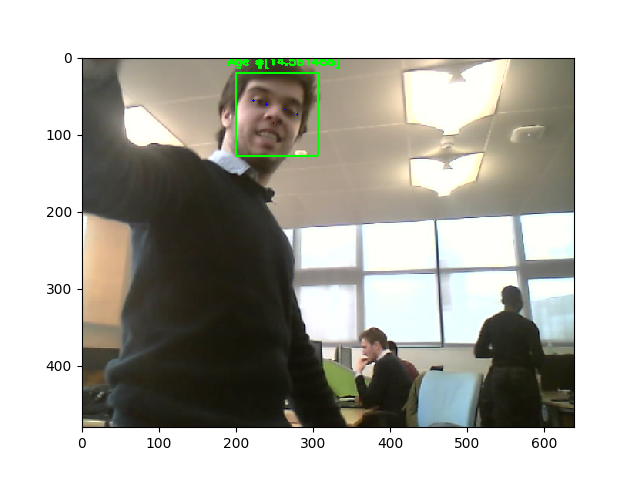

[4.6916027]
[10.0827055]
[9.6506195]
[12.499188]
[12.751517]
[13.851451]
[15.238722]
[18.582855]
[8.051546]
[13.242249]
[4.5559187]
[9.256874]
[5.807168]
[12.391554]
[13.861635]
[13.361263]
[20.259888]
[9.936916]
[17.802055]
[16.94041]
[14.712787]
[10.59403]
[19.61396]
[23.291485]
[21.499973]
[13.23028]
[20.724764]
[18.964111]
[17.665962]
[17.969927]
[16.2875]
[8.551039]
[6.4559364]
[8.243004]
[13.988841]
[11.717004]
[13.2157345]
[9.880217]
[14.961271]
[16.288406]
[16.570564]
[15.825045]
[16.483168]
[14.346531]
[13.953527]
[14.19368]
[16.462008]
[14.911325]
[10.21114]
[10.859488]
[12.865896]
[14.730402]
[13.454529]
[15.795225]
[16.501892]
[16.759224]
[16.96354]
[17.395706]
[17.33976]
[17.963465]
[17.732779]
[16.745514]
[7.2746124]
[10.514114]
[9.296191]
[16.888542]
[14.628189]
[19.249952]
[17.750282]
[16.320362]
[18.067024]
[13.818346]
[22.035185]
[21.229397]
[20.29887]
[16.748684]
[19.446896]
[18.47919]
[18.32703]
[18.62225]
[19.012466]
[17.553598]
[17.698578]
[18.556053]
[18.918633]


error: OpenCV(3.4.1-dev) /root/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215) Assertion failed: ssize.width > 0 && ssize.height > 0 in function resize


In [11]:
import matplotlib.pyplot as plt
import signal

%matplotlib notebook

def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

video_capture = cv2.VideoCapture(0)

f = plt.figure()

if video_capture.isOpened(): # try to get the first frame
    is_capturing, frame = video_capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
    shape = frame.shape
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

count = 0

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
ages = np.arange(0, 101).reshape(101, 1)

while(is_capturing):
    # Capture frame-by-frame
    is_capturing, image = video_capture.read()
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    dets = detector(image, 1)
    
    # loop over the face detections
    
    for (i, rect) in enumerate(dets):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        face = image[x:x+w,y:y+h]
        
        face = [cv2.resize(face,(224,224))]
        
        y_pred = model.predict(np.array(face))
        
        
        predicted_age = y_pred[0].dot(ages).flatten()
        predicted_age_regressed = y_pred[1]

        avg = (predicted_age[0] + predicted_age_regressed[0])/2
        
        print(avg)

        cv2.putText(image, "Age {}".format(avg), (x - 10, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    
    
    webcam_preview.set_data(image)

    f.canvas.draw()
    
    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.02)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break

In [ ]:
%matplotlib notebook
import cv2
import matplotlib.pyplot as plt
import signal

def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

vc = cv2.VideoCapture(0)

f = plt.figure()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
while is_capturing:
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview.set_data(frame)
    f.canvas.draw()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.03)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break